In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/TFM'

/content/drive/MyDrive/Colab Notebooks/TFM


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [ ]:
with open('dataset_X_y_sliding_window.npy', 'rb') as f:
    lista_datos = np.load(f, allow_pickle=True)

X_train = lista_datos[0]
X_valid = lista_datos[1]
X_test = lista_datos[2]
y_train = lista_datos[3]
y_valid = lista_datos[4]
y_test = lista_datos[5]


In [ ]:
print(y_valid[490:510])

['joy' 'joy' 'joy' 'joy' 'joy' 'joy' 'joy' 'joy' 'joy' 'joy' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral']


In [ ]:

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_valid = encoder.transform(y_valid)
y_test = encoder.transform(y_test)

In [ ]:
print(y_valid[490:510])

[1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]


In [ ]:
print(X_train.shape)

(8638, 100, 32)


In [ ]:
inputs = tf.keras.Input(shape=(X_train.shape[1],X_train.shape[2]))

gru = tf.keras.layers.GRU(256, return_sequences=True)(inputs)
flatten = tf.keras.layers.Flatten()(gru)
outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)

rnn_model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(rnn_model.summary())

rnn_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
optimizer=Adam(0.001),
metrics=["accuracy"])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100, 256)            │         222,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │          76,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 299,523 (1.14 MB)

 Trainable params: 299,523 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
input_shape = X_train.shape[1:]
opt = Adam(0.001)
rnn_model = Sequential()
drp=0.2

rnn_model.add(Input(shape=input_shape))
rnn_model.add(BatchNormalization())
rnn_model.add(LSTM((64), return_sequences=True))
rnn_model.add(LSTM((32)))
rnn_model.add(Dropout(drp))
rnn_model.add(Dense(2, activation='softmax'))
rnn_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
optimizer=opt,
metrics=["accuracy"])
rnn_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_11               │ (None, 100, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 100, 64)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,442 (146.26 KB)

 Trainable params: 37,378 (146.01 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
model_checkpoint_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience = 10, verbose = 1, min_delta=0.01)
history = rnn_model.fit(X_train, y_train, batch_size=32, epochs=1000, callbacks=[model_checkpoint_callback], validation_data=(X_valid, y_valid))
res = rnn_model.predict(X_test)
print(model_checkpoint_callback.best)
y_pred = np.argmax(res, axis = 1)

Epoch 1/1000
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3625 - loss: 2.7849 - val_accuracy: 0.3190 - val_loss: 2.6862
Epoch 2/1000
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4430 - loss: 2.1023 - val_accuracy: 0.3138 - val_loss: 2.8819
Epoch 3/1000
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4767 - loss: 1.9492 - val_accuracy: 0.3221 - val_loss: 3.1980
Epoch 4/1000
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4988 - loss: 1.7136 - val_accuracy: 0.3325 - val_loss: 3.0890
Epoch 5/1000
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5103 - loss: 1.8163 - val_accuracy: 0.3044 - val_loss: 2.8299
Epoch 6/1000
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5251 - loss: 1.8349 - val_accuracy: 0.3388 - val_loss: 3.4670
Epoch 7/1000
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5521 - loss: 1.6403 - val_accuracy: 0.3277 - val_loss: 2.9519
Epoch 8/1000
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5636 - loss: 1.4854 

In [ ]:
from tensorflow.keras.layers import Conv1D

X_train_cnn = X_train.reshape(864000, 32, 1)
X_valid_cnn = X_test.reshape(288000, 32, 1)
X_train_cnn = X_test.reshape(288000, 32, 1)

opt = Adam(0.001)
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(32, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(3, activation='softmax'))
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
optimizer=opt,
metrics=["accuracy"])
model_cnn.summary()

ValueError: cannot reshape array of size 31596544 into shape (864000,32,1)

In [ ]:
model_checkpoint_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience = 10, verbose = 1, min_delta=0.01)
history = model_cnn.fit(X_train, y_train, batch_size=32,epochs=1000, callbacks=[model_checkpoint_callback], validation_data=(X_valid, y_valid))
res = model_cnn.predict(X_test)
print(model_checkpoint_callback.best)
y_pred = np.argmax(res, axis = 1)

Epoch 1/1000
27000/27000 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - accuracy: 0.3435 - loss: 1.2075 - val_accuracy: 0.3336 - val_loss: 1.0988
Epoch 2/1000
27000/27000 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step - accuracy: 0.3419 - loss: 1.0941 - val_accuracy: 0.3322 - val_loss: 1.1048
Epoch 3/1000
27000/27000 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - accuracy: 0.3463 - loss: 1.0924 - val_accuracy: 0.3353 - val_loss: 1.1038
Epoch 4/1000
27000/27000 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - accuracy: 0.3448 - loss: 1.0920 - val_accuracy: 0.3346 - val_loss: 1.1139
Epoch 5/1000
27000/27000 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - accuracy: 0.3462 - loss: 1.0913 - val_accuracy: 0.3343 - val_loss: 1.1166
Epoch 6/1000
27000/27000 ━━━━━━━━━━━━━━━━━━━━ 143s 3ms/step - accuracy: 0.3446 - loss: 1.0911 - val_accuracy: 0.3364 - val_loss: 1.1164
Epoch 7/1000
18558/27000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.3483 - loss: 1.0888

KeyboardInterrupt: 

In [ ]:
p = confusion_matrix(y_test, y_pred, labels=[0,1])

# list all data in history
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


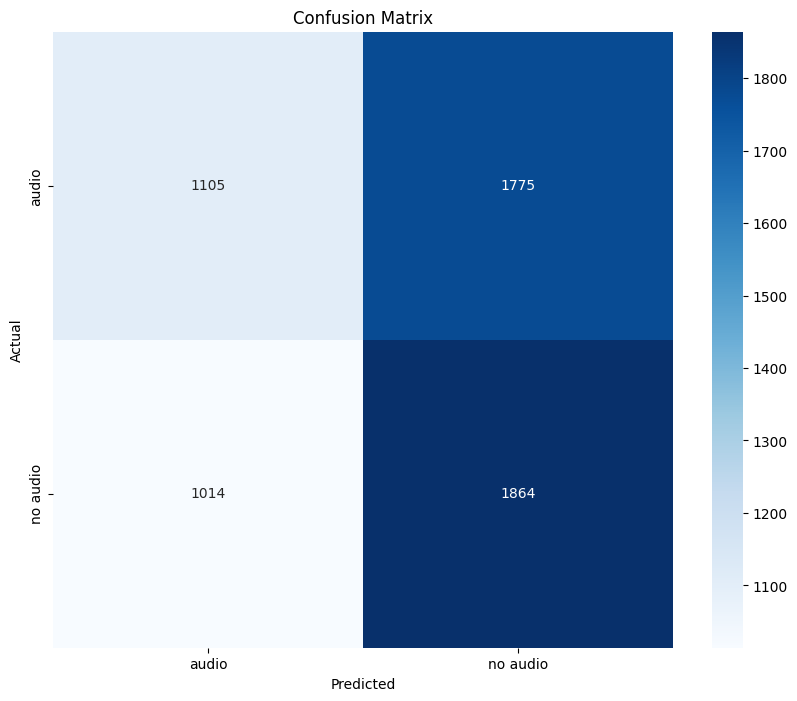

In [ ]:
# prompt: print confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(p, annot=True, fmt="d", cmap="Blues", xticklabels=['audio', 'no audio'], yticklabels=['audio', 'no audio'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
